In [1]:
import pandas as pd
import rootutils
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import seaborn as sns

np.random.seed(123)

root = rootutils.setup_root(search_from=".", indicator=".git")

DATA_DIR = root / "data" / "processed"

read data

In [2]:
data = pd.read_parquet(DATA_DIR / "raw_data.parquet")

plot method

In [3]:
def plot_data(data, title, duration=None):

    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("DataFrame muss einen datetime index haben (data.set_index('time'))")
    
    if duration:
        start_time = data.index.min()
        end_time = start_time + pd.Timedelta(seconds=duration)
        data = data[(data.index >= start_time) & (data.index <= end_time)]

    plt.figure(figsize=(12, 4))
    plt.plot(data.index, data['x'], label='x', linewidth=1)
    plt.plot(data.index, data['y'], label='y', linewidth=1)
    plt.plot(data.index, data['z'], label='z', linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

random file

In [4]:
data = data[data['file_hash'] == data['file_hash'].sample(1).values[0]]
data = data.rename(columns={'accelerometer_x': 'x', 'accelerometer_y': 'y', 'accelerometer_z': 'z'})

setzt time to datetime und als index

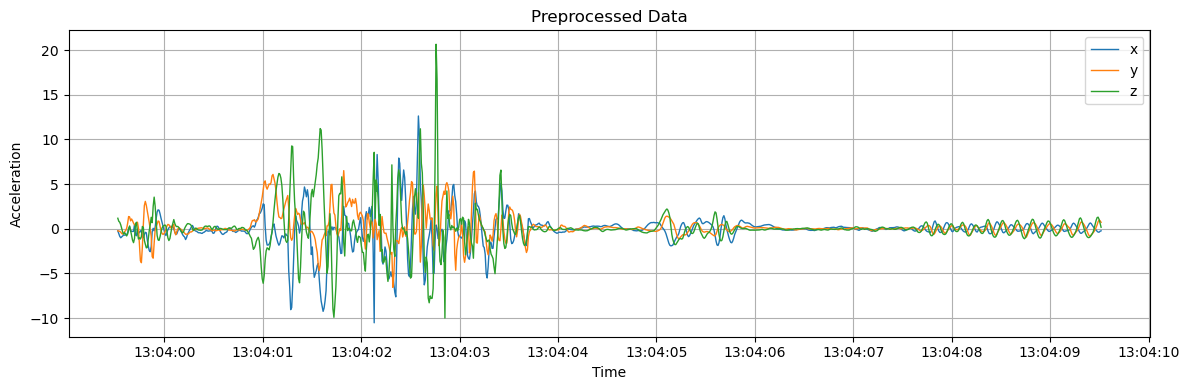

In [5]:
file_data = data.copy()
file_data['time'] = pd.to_datetime(file_data['time'], unit='ns')
file_data = file_data.set_index('time', drop=True)
file_data = file_data.sort_index()
plot_data(file_data, "Preprocessed Data", duration=10)

zuschneidung der ersten und letzten 8 sekunden, da dort das Gerät (Handy) gestartet wurde und das Handy sich anders bewegt hat als dass es in der Hosentasche ist.

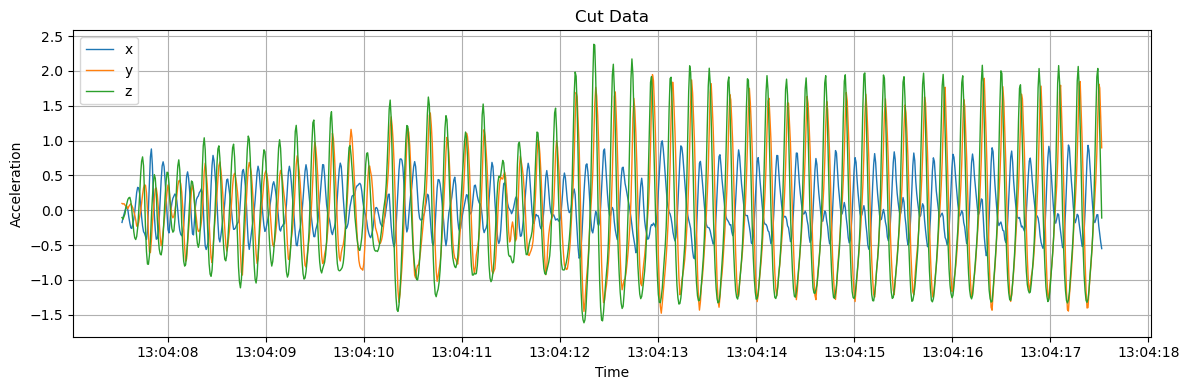

In [6]:
# cut the first and last 8 seconds of the file_data
cut_start = file_data.index[0] + pd.Timedelta(seconds=8)
cut_end = file_data.index[-1] - pd.Timedelta(seconds=8)
cropped_data = file_data[(file_data.index >= cut_start) & (file_data.index <= cut_end)]
plot_data(cropped_data.copy(), "Cut Data", duration=10)

In [14]:
def plot_resample(original_df, resampled_df):

    if not isinstance(original_df.index, pd.DatetimeIndex) or not isinstance(resampled_df.index, pd.DatetimeIndex):
        raise ValueError("DataFrames müssen einen datetime index haben.")
    
    plt.figure(figsize=(14, 5))

    # Plot Originaldaten
    for axis, color in zip(['x', 'y', 'z'], ['red', 'green', 'blue']):
        col = [c for c in original_df.columns if axis in c][0]
        plt.plot(original_df.index, original_df[col], label=f"{axis.upper()} Original", color=color, alpha=0.2)

    # Plot Resampleddaten
    for axis, color in zip(['x', 'y', 'z'], ['red', 'green', 'blue']):
        col = [c for c in resampled_df.columns if axis in c][0]
        plt.plot(resampled_df.index, resampled_df[col], label=f"{axis.upper()} Resampled", color=color, linestyle="--")

    plt.title("Original vs. Resampled (x, y, z nacheinander)")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

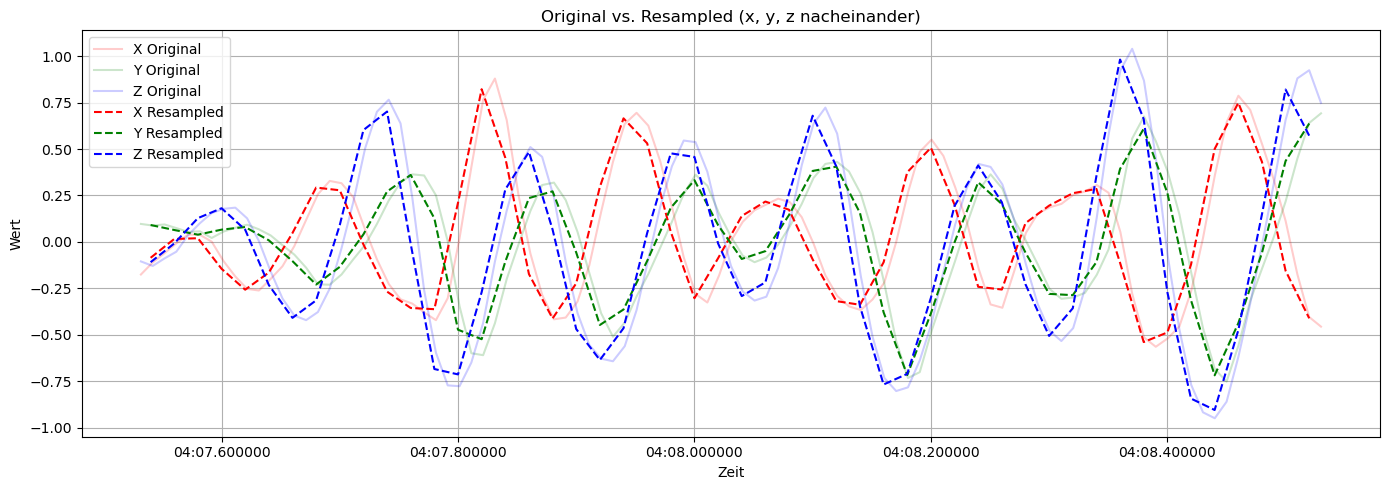

In [15]:
numeric_columns = cropped_data.select_dtypes(include='number').columns
cropped_data_numeric = cropped_data[numeric_columns]

rate = f"{int(1E6 / 50)}us"
resampled_data = cropped_data_numeric.resample(rate).mean()  # 100 Hz => 50 Hz == 1E6 / 50 us 

start_time = cropped_data_numeric.index[0]
end_time = start_time + pd.Timedelta(seconds=1)
cropped_data_subset = cropped_data_numeric[start_time:end_time]
resampled_data_subset = resampled_data[start_time:end_time]

plot_resample(cropped_data_subset, resampled_data_subset)

segmentierung

Number of segments: 59


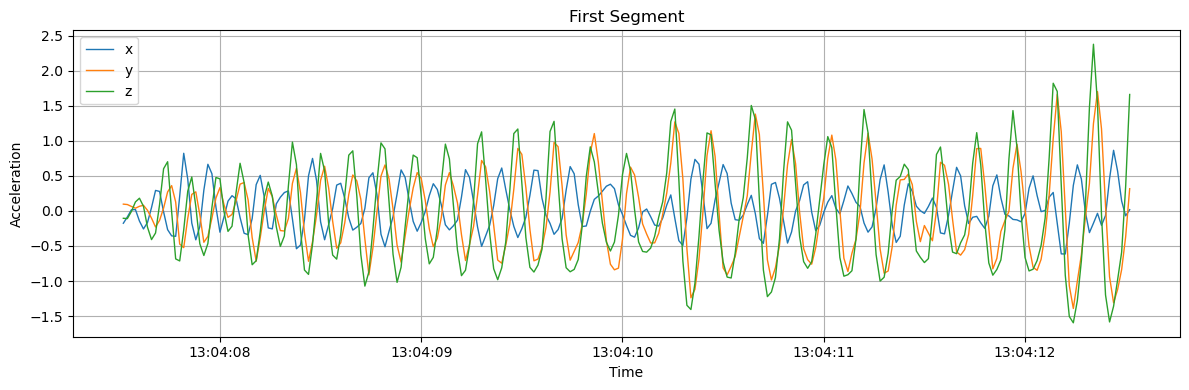

In [16]:
segment_size = pd.Timedelta(seconds=5)
overlap = pd.Timedelta(seconds=2)

start_time = resampled_data.index.min()
segments = []

while start_time + segment_size <= resampled_data.index.max():
    end_time = start_time + segment_size
    segments.append(resampled_data[start_time:end_time])
    start_time = end_time - overlap
    
print(f'Number of segments: {len(segments)}')
plot_data(segments[0], 'First Segment')

In [17]:
def plot_segment_overlap(segments, column='x'):

    if len(segments) < 2:
        raise ValueError("Mindestens zwei Segmente erforderlich.")
    
    # Spalte suchen (z. B. 'accelerometer_x', 'gyroscope_x', etc.)
    colname = [c for c in segments[0].columns if column in c]
    if not colname:
        raise ValueError(f"Keine Spalte mit '{column}' gefunden.")
    colname = colname[0]

    seg0 = segments[0][colname]
    seg1 = segments[1][colname]

    plt.figure(figsize=(12, 4))
    plt.plot(seg0.index, seg0.values, label='Segment 0', color='blue')
    plt.plot(seg1.index, seg1.values, label='Segment 1', color='orange', linestyle='--')
    plt.title(f"Overlap der Segmente – Spalte '{colname}'")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

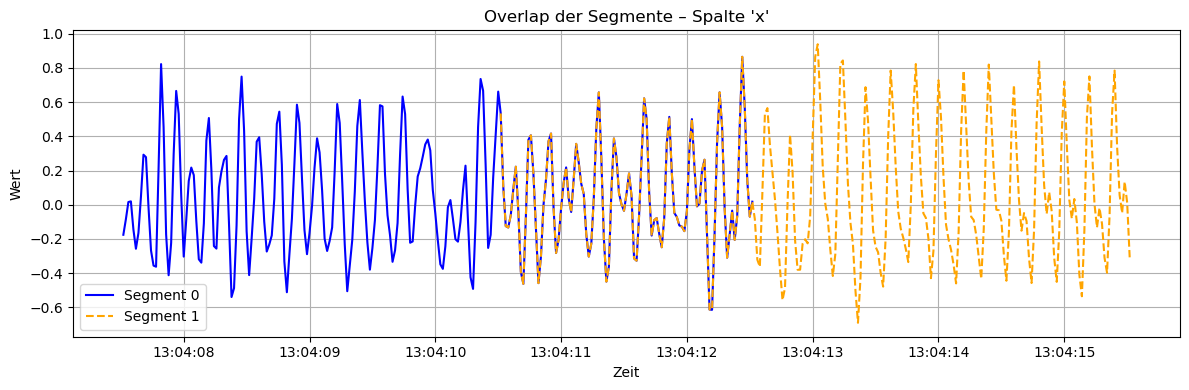

In [21]:
plot_segment_overlap(segments[:3])

feature extraction

Frequency Domain

In [23]:
def plot_frequency_domain(data, sampling_rate, title):

    if isinstance(data, pd.Series):
        data = data.values

    n = len(data)
    freq = np.fft.rfftfreq(n, d=1.0 / sampling_rate)  # positive Frequenzen
    fft_magnitude = np.abs(np.fft.rfft(data))         # Betrag der komplexen FFT-Werte

    plt.figure(figsize=(10, 4))
    plt.plot(freq, fft_magnitude)
    plt.title(f"FFT – {title}")
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

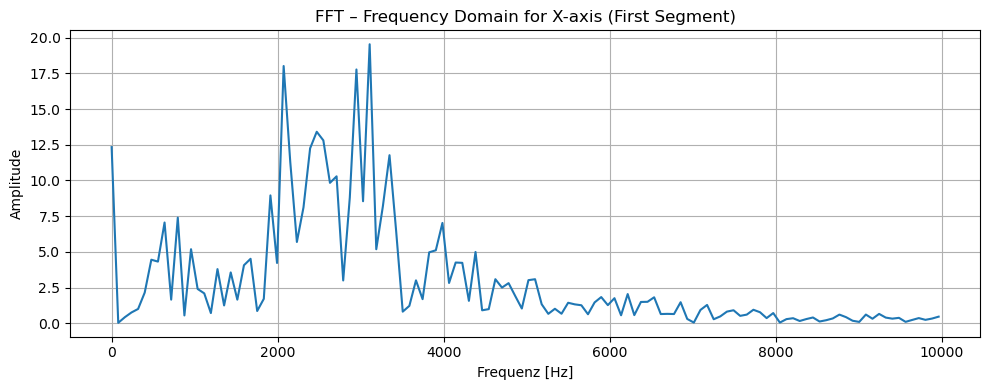

In [24]:
plot_frequency_domain(segments[0]['x'], 1E6 / 50, title='Frequency Domain for X-axis (First Segment)')

correlation heatmap

In [31]:
def plot_correlation_heatmap(data, title):

    data = data.copy().rename(columns={
        'x': 'accelerometer_x', 
        'y': 'accelerometer_y', 
        'z': 'accelerometer_z'}
        )
    
    data = data.drop(columns=['seconds_elapsed'], errors='ignore')
    
    correlation_matrix = data.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                fmt='.2f', cbar=True, square=True, annot_kws={'size': 10}, 
                mask=np.triu(correlation_matrix, k=1))
    plt.title(title)
    plt.show()

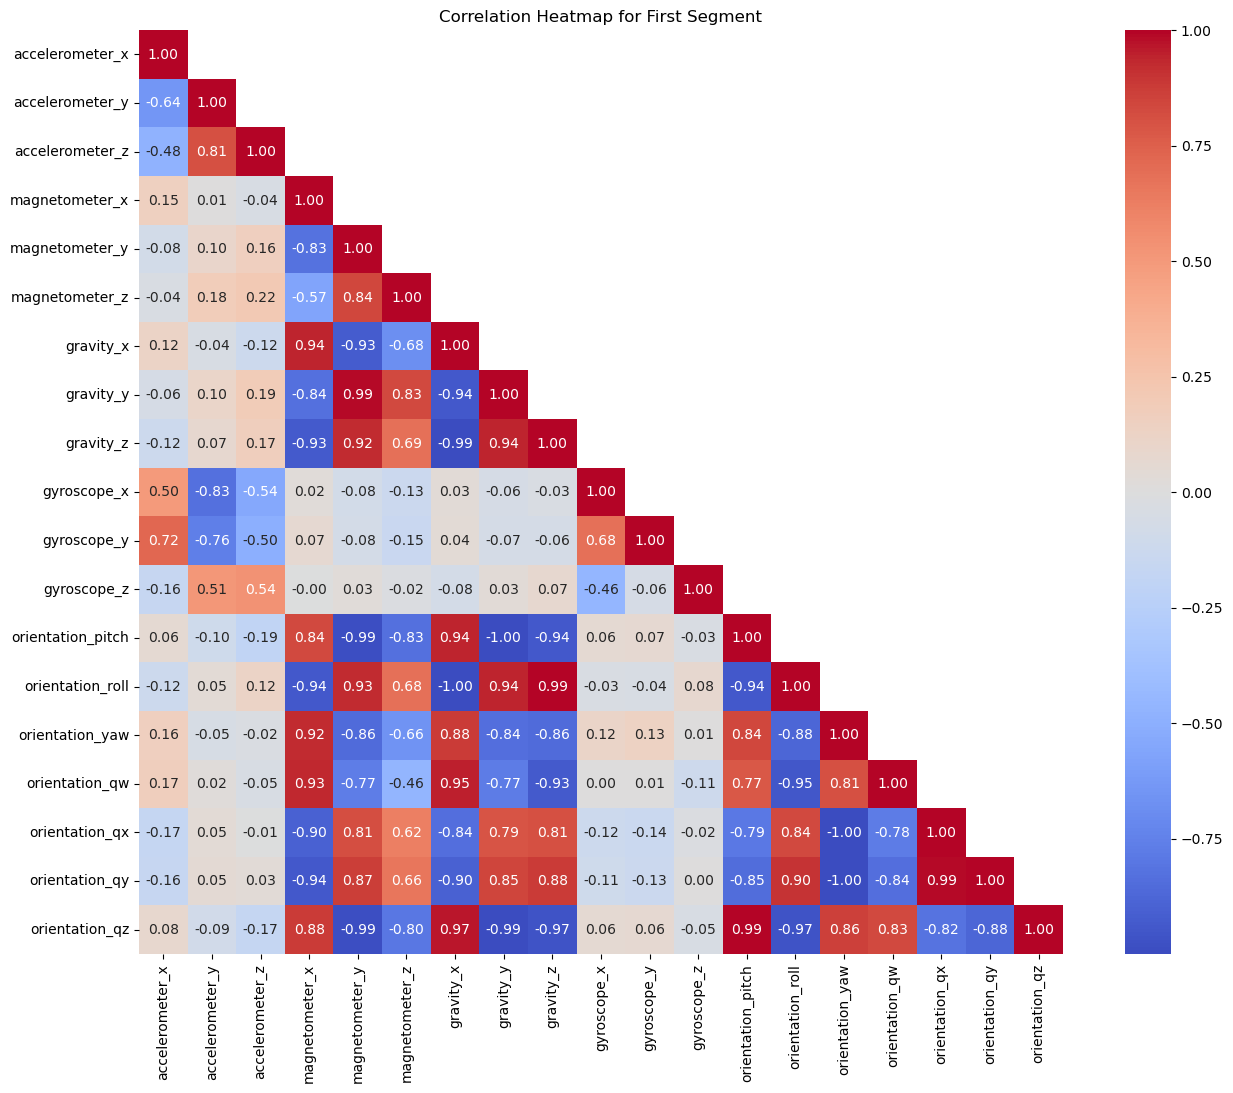

In [32]:
plot_correlation_heatmap(segments[0].copy(), title='Correlation Heatmap for First Segment')

butterworth filter

In [37]:
from scipy.signal import butter, filtfilt

def compute_butterworth_coefficients(order, cutoff_hz, sampling_rate):
    """
    Berechnet die Koeffizienten für einen digitalen Butterworth-Tiefpassfilter.
    """
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff = cutoff_hz / nyquist_freq
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    return b, a

def apply_butterworth_filter_to_series(series, order, cutoff_hz, sampling_rate):
    """
    Wendet den Butterworth-Filter auf eine Zeitreihe an und gibt eine Series mit Zeitindex zurück.
    """
    b, a = compute_butterworth_coefficients(order, cutoff_hz, sampling_rate)
    filtered_values = filtfilt(b, a, series)
    return pd.Series(filtered_values, index=series.index)

def plot_butterworth_filter_result(original_series, filtered_series, title="Butterworth Filter Result"):
    """
    Visualisiert Originaldaten und gefilterte Daten in einem Plot.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(original_series.index, original_series.values, label="Original", alpha=0.5)
    plt.plot(filtered_series.index, filtered_series.values, label="Gefiltert", linestyle="--", color="orange")
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

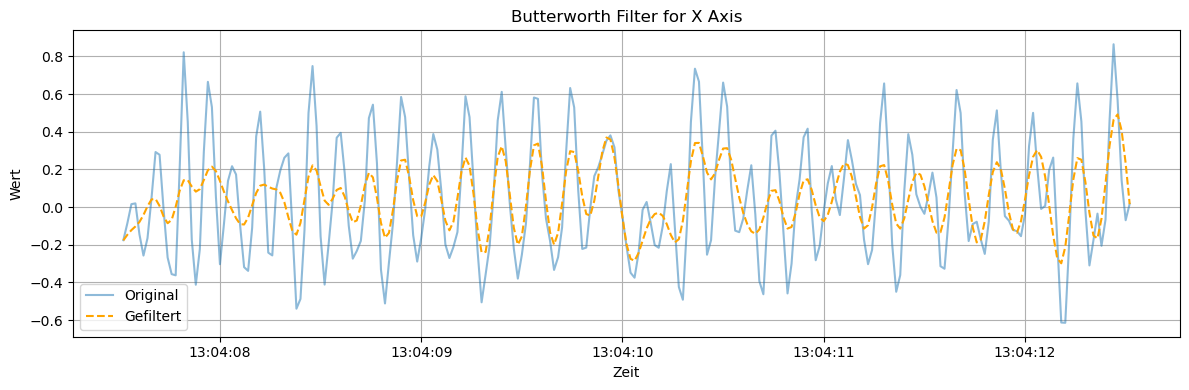

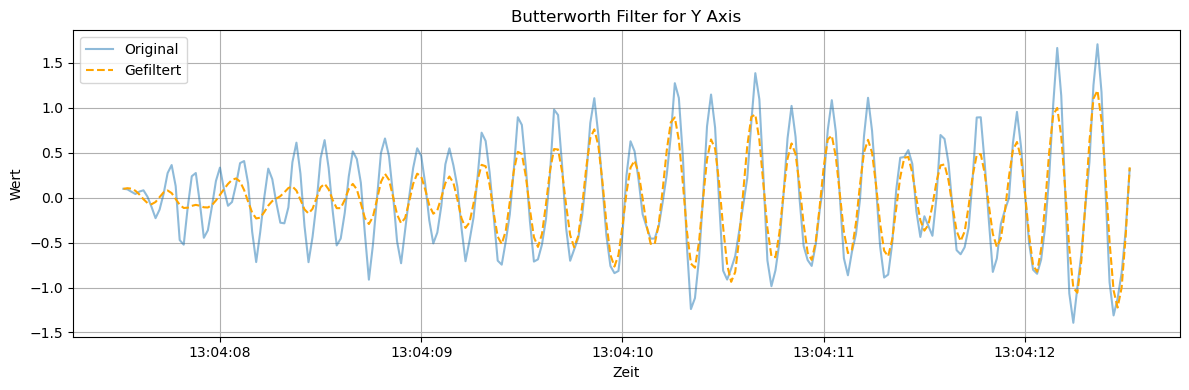

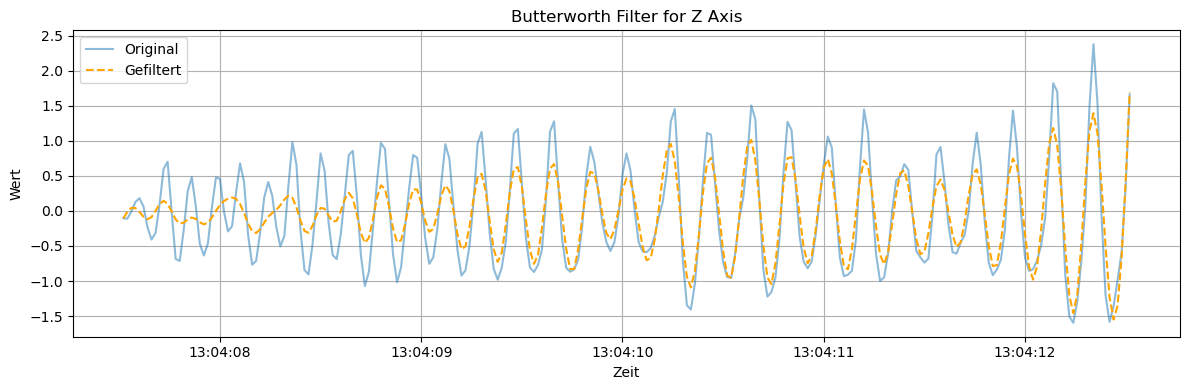

In [38]:
butterworth_segment = segments.copy()[0]
cutoff, order = 6, 4
sampling_rate = 50
for column in ['x', 'y', 'z']:
    filtered_data = apply_butterworth_filter_to_series(butterworth_segment[column], order, cutoff, sampling_rate)
    plot_butterworth_filter_result(butterworth_segment[column], filtered_data, title=f"Butterworth Filter for {column.upper()} Axis")

In [43]:
def apply_moving_average_filter(segment_df, window_seconds, sampling_rate, columns=['x', 'y', 'z']):
    """
    Wendet einen gleitenden Durchschnitt auf bestimmte Spalten eines Segments an.

    Args:
        segment_df (pd.DataFrame): Segment mit Zeitindex und Sensorachsen.
        window_seconds (float): Fensterbreite in Sekunden.
        sampling_rate (float): Sampling-Rate in Hz.
        columns (list): Liste der Spaltennamen wie ['x', 'y', 'z'].
    
    Returns:
        pd.DataFrame: Segment mit geglätteten Werten in den angegebenen Spalten.
    """
    df_smoothed = segment_df.copy()
    window_size = int(window_seconds * sampling_rate)

    for col in columns:
        if col not in df_smoothed.columns:
            continue
        smoothed = df_smoothed[col].rolling(window=window_size, center=True).mean()
        df_smoothed[col] = smoothed.bfill().ffill()  # Aktualisierte Methode
    
    return df_smoothed

def plot_moving_average(original_df, smoothed_df, axis='x', title='Moving Average Filter'):
    """
    Zeigt Original- und geglättete Kurve für eine Achse (z. B. x) im Vergleich.

    Args:
        original_df (pd.DataFrame): Ursprungsdaten mit Zeitindex.
        smoothed_df (pd.DataFrame): Gefilterte Daten mit Zeitindex.
        axis (str): Achsenbezeichnung ('x', 'y', 'z').
        title (str): Plot-Titel.
    """
    col = axis if axis in original_df.columns else f"accelerometer_{axis}"
    
    plt.figure(figsize=(12, 4))
    plt.plot(original_df.index, original_df[col], label="Original", alpha=0.5)
    plt.plot(smoothed_df.index, smoothed_df[col], label="Moving Average", linestyle='--')
    plt.title(f"{title} – Achse {axis.upper()}")
    plt.xlabel("Zeit")
    plt.ylabel("Wert")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

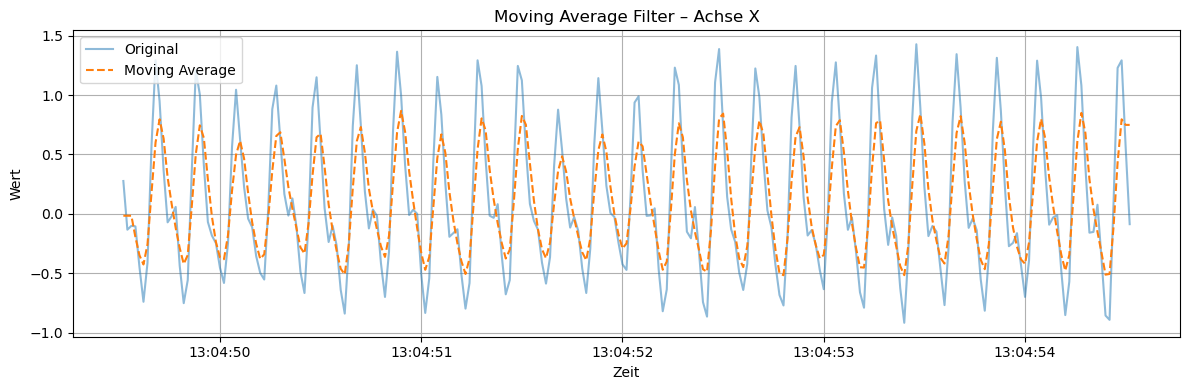

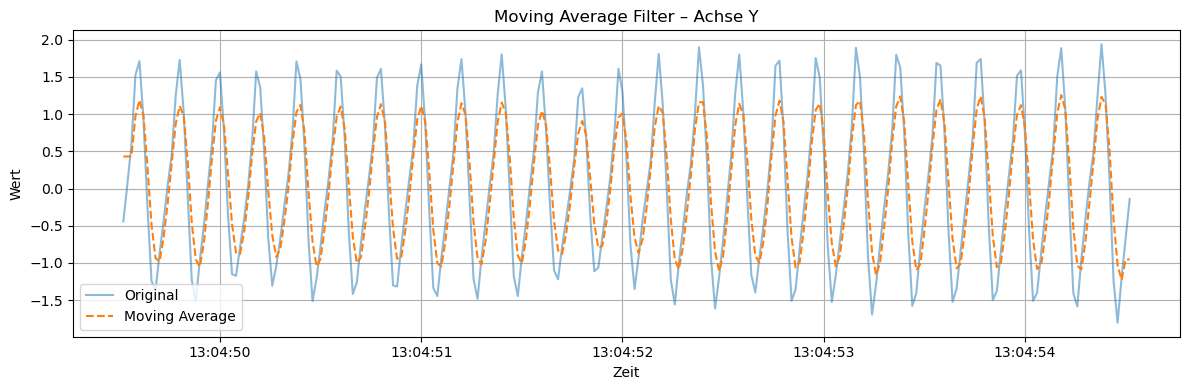

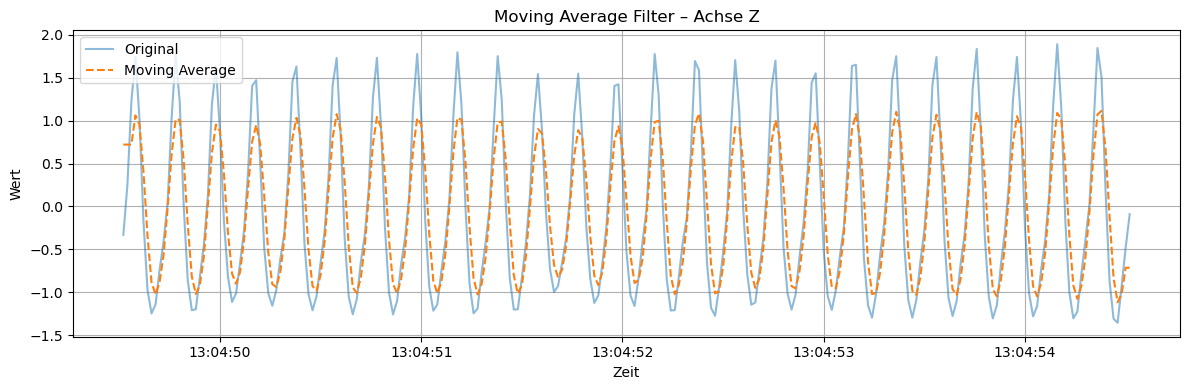

In [44]:
import random

segment = random.choice(segments).copy()

# Gleitenden Durchschnitt anwenden
smoothed = apply_moving_average_filter(segment, window_seconds=0.2, sampling_rate=20)

# Visualisieren für alle Achsen
for ax in ['x', 'y', 'z']:
    plot_moving_average(segment, smoothed, axis=ax)

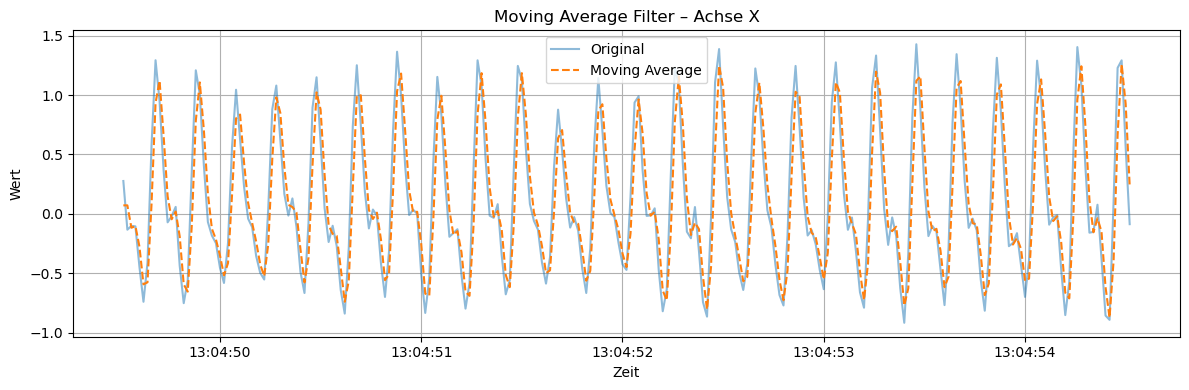

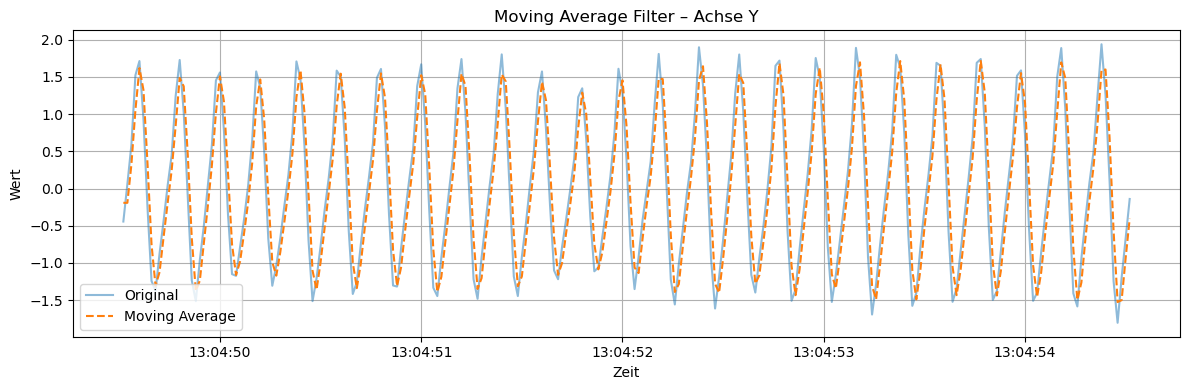

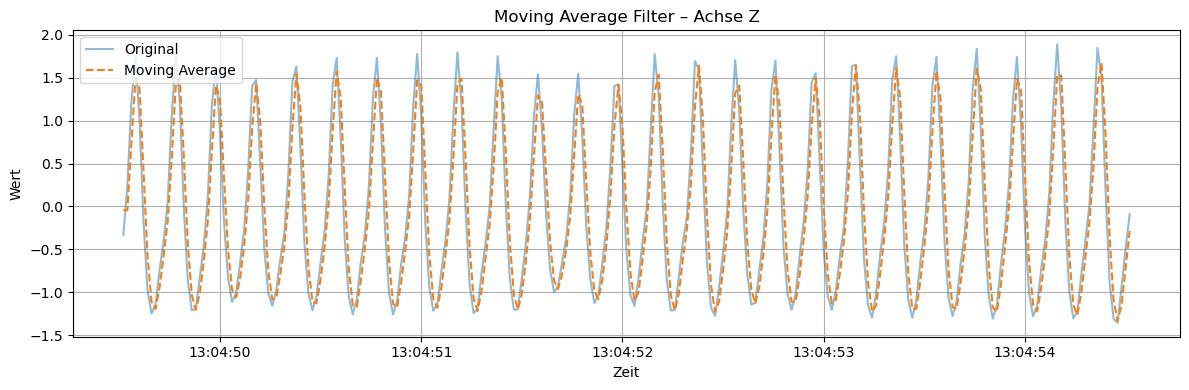

In [45]:
# Gleitenden Durchschnitt anwenden
smoothed = apply_moving_average_filter(segment, window_seconds=0.1, sampling_rate=20)

# Visualisieren für alle Achsen
for ax in ['x', 'y', 'z']:
    plot_moving_average(segment, smoothed, axis=ax)